In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pyro.distributions.constraints as constraints
import scipy
import scipy.optimize as opt

In [3]:
import os
import matplotlib.pyplot as plt
import torch
import numpy as np


import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist

from matplotlib.animation import FuncAnimation
from mpl_toolkits.axes_grid1 import make_axes_locatable

from sklearn.model_selection import train_test_split
pyro.set_rng_seed(0)

In [4]:
#B1

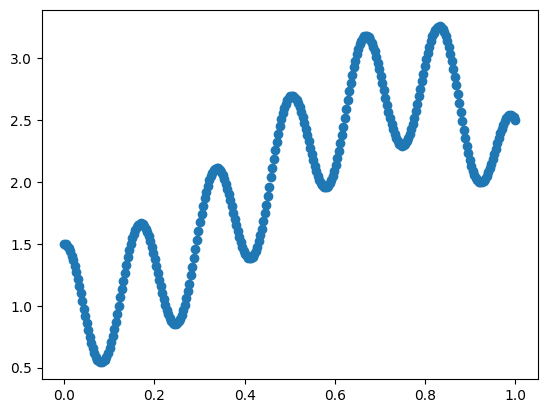

In [5]:
#Objective function
def g(x):
    return - torch.sin(6*torch.pi*x)**2 + 6 * x**2 - 5*x**4 + 3 / 2
grid = torch.linspace(0, 1, 300)
plt.scatter(x = grid, y = g(grid))
plt.show()

In [6]:
# let's plot the loss curve after 2000 steps of training
def plot_loss(loss):
    plt.plot(loss)
    plt.xlabel("Iterations")
    _ = plt.ylabel("Loss")  # supress output text

In [7]:
n = 30
X = torch.linspace(0, 1, 30).reshape((-1,1))
y = g(X) + dist.Normal(0.0, np.sqrt(0.01)).sample(sample_shape=(30,)).reshape((-1,1))
X, X_test, y, y_test = train_test_split(X, y, test_size=10, random_state = 45)
#Consider normalise ys:
#y_mean = torch.mean(y)
#y_std = torch.std(y)
#y = (y - y_mean)/y_std

In [6]:
#numpy version
n = 30
X = torch.linspace(0, 1, 30).reshape((-1,1))
y = g(X) + dist.Normal(0.0, np.sqrt(0.01)).sample(sample_shape=(30,)).reshape((-1,1))
X, X_test, y, y_test = train_test_split(X, y, test_size=10, random_state=45)
#normalise ys:
#y = (y - torch.mean(y))/torch.std(y)
y = np.array(y)
X = np.array(X)

In [8]:
smoke_test = False
def plot(
    plot_observed_data=False,
    plot_predictions=False,
    plot_target_function=False,
    plot_test_data=False,
    n_prior_samples=0,
    model=None,
    kernel=None,
    n_test=500,
    ax=None,
    nump=True
):

    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))
    if plot_target_function:
        ax.plot(torch.linspace(-0.5,5.5, n_test), g(torch.linspace(-0.5,5.5, n_test)))
    if plot_observed_data:
        if not nump: 
            ax.plot(X.numpy(), y.numpy(), "kx")
        else:
            ax.plot(X, y, "kx")
    if plot_test_data:
        if not nump: 
            ax.plot(X_test.numpy(), y_test.numpy(), "o")
        else:
            ax.plot(X_test.numpy(), y_test.numpy(), "o")
    if plot_predictions:
        Xtest = torch.linspace(-0.5, 5.5, n_test)  # test inputs
        # compute predictive mean and variance
        with torch.no_grad():
            if type(model) == gp.models.VariationalSparseGP:
                mean, cov = model(Xtest, full_cov=True)
            else:
                mean, cov = model(Xtest, full_cov=True, noiseless=False)
        #var_gp = torch.diag(cov)
        #yout_m = mean*y_std + y_mean
        #yout_v =var_gp*y_std**2
        
        sd = cov.diag().sqrt()  # standard deviation at each input point x
        ax.plot(Xtest.numpy(), mean.numpy(), "r", lw=2)  # plot the mean
        ax.fill_between(
            Xtest.numpy(),  # plot the two-sigma uncertainty about the mean
            (mean - 2.0 * sd).numpy(),
            (mean + 2.0 * sd).numpy(),
            color="C0",
            alpha=0.3,
        )
    if n_prior_samples > 0:  # plot samples from the GP prior
        Xtest = torch.linspace(-0.5, 2, n_test)  # test inputs
        noise = (
            model.noise
            if type(model) != gp.models.VariationalSparseGP
            else model.likelihood.variance
        )
        cov = kernel.forward(Xtest) + noise.expand(n_test).diag()
        samples = dist.MultivariateNormal(
            torch.zeros(n_test), covariance_matrix=cov
        ).sample(sample_shape=(n_prior_samples,))
        ax.plot(Xtest.numpy(), samples.numpy().T, lw=2, alpha=0.4)

    ax.set_xlim(-0.2, 1.2)
    ax.set_ylim(-3,5)

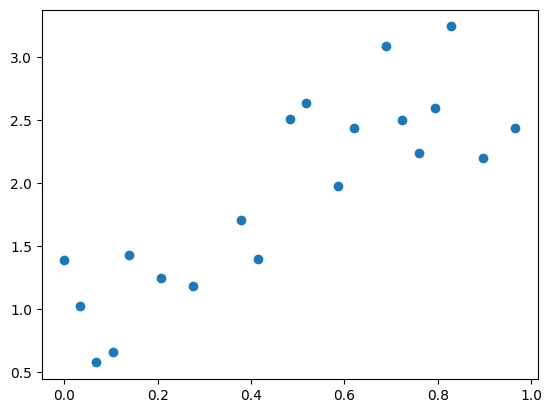

In [9]:
plt.scatter(x = X, y = y)

In [10]:
# Define the same model as before.
pyro.clear_param_store()
pyro.set_rng_seed(50) #seed 46 gives good prior
kernel_per = gp.kernels.Periodic(input_dim = 1)
kernel_lin = gp.kernels.Linear(input_dim = 1)
kernel_Rbf = gp.kernels.RBF(input_dim=1)
kernel_sum = gp.kernels.Sum(kernel_lin, kernel_per)

gpr = gp.models.GPRegression(X = X.flatten(), y = y.flatten(), kernel = kernel_sum, noise=torch.tensor(0.1), jitter=2e-3)

gpr.kernel.kern0.variance = pyro.nn.PyroSample(dist.LogNormal(0,5)) #I think normal not allowed 

gpr.kernel.kern1.variance = pyro.nn.PyroSample(dist.InverseGamma(3,2)) 
gpr.kernel.kern1.lengthscale = pyro.nn.PyroSample(dist.InverseGamma(3,1))
gpr.kernel.kern1.period = pyro.nn.PyroSample(dist.InverseGamma(3,1))


In [11]:
#Run model to initialise values
gpr(X.flatten())
param_store = pyro.get_param_store()
param_store.keys()
#See initialised values.
for i, (name, value) in enumerate(param_store.items()):
    print(f"Parameter: {name}, Value: {value}")

Parameter: kernel.kern0.variance_map, Value: 10.099201202392578
Parameter: kernel.kern1.period_map, Value: 1.1264420747756958
Parameter: kernel.kern1.lengthscale_map, Value: 0.5812376141548157
Parameter: kernel.kern1.variance_map, Value: 0.8334131240844727
Parameter: noise, Value: 0.09999999403953552


In [12]:
#This computes exactly the posterior as given on p.48 in GP algorithm (simple)
#Before training we consider this the prior likelihood on the test data
loc_prior, cov_prior = gpr(X_test.flatten(), full_cov = True)

In [13]:
#Just the log likelihood of a multivariate gaussian
def LogLikelihood(loc, cov, y):
    #Not sure if use noise variable, but here goes:
    #If needed then give model as argument as well and
    #noise_y = model.noise.detach().numpy()
    #Fix shapes:
    loc = loc.reshape_as(y)
    #Compute logdet
    sign, det = np.linalg.slogdet(cov.detach().numpy())
    logdet = sign*det
    #Compute loglikelihood:
    ll = (-1/2*(y.numpy()-loc.detach().numpy()).T @ np.linalg.inv(cov.detach().numpy()) @ (y.numpy()-loc.detach().numpy()) 
             - 1/2 * logdet - y.shape[0]/2 * np.log(2*np.pi)) 
    if np.isinf(ll):
        return np.inf
    return ll

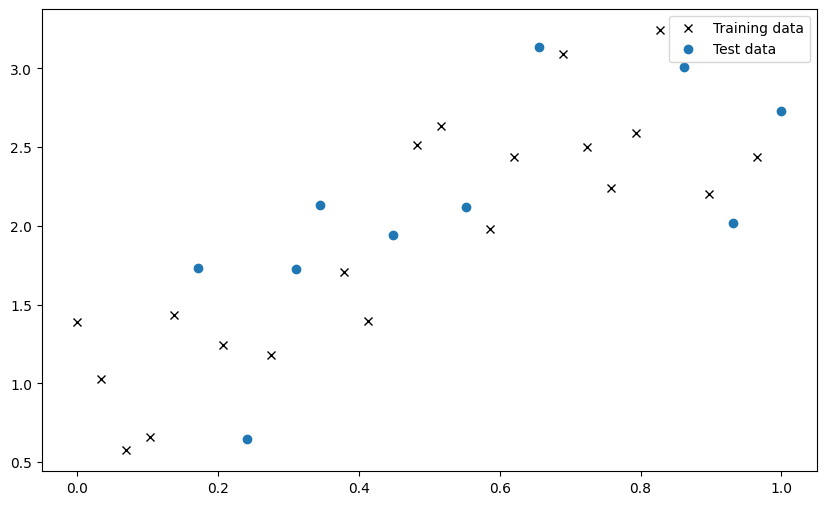

In [14]:
#Plot data:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(X.numpy(), y.numpy(), "kx")
ax.plot(X_test.numpy(), y_test.numpy(), "o")
ax.legend(["Training data", "Test data"])

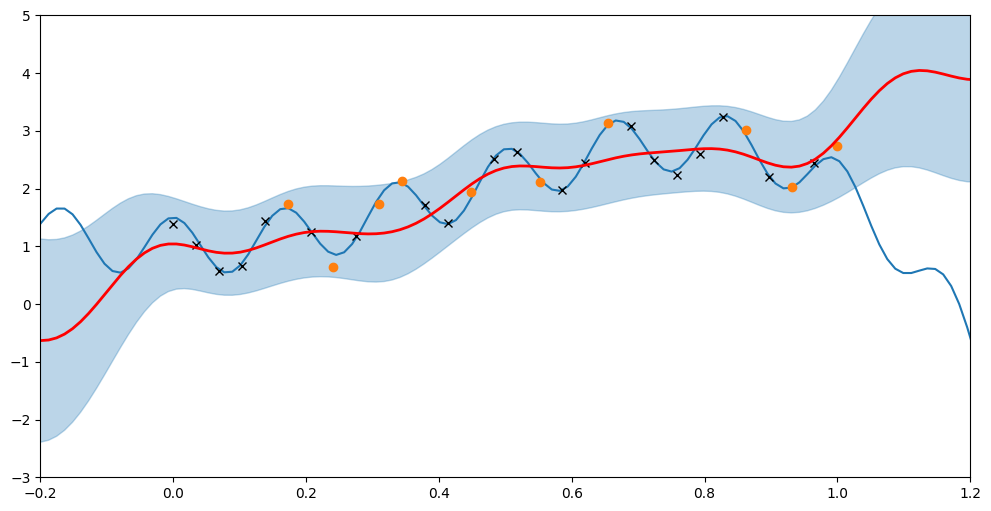

In [15]:
#Plotting the model and prior fit to training data
plot(model = gpr, plot_observed_data=True, plot_test_data = True, plot_predictions=True, plot_target_function=True)  # let's plot the observed data

In [16]:
#Inspired by pyros implementation of kernels
# def kernel_per_(X, Xprime, eta):
#     var = eta[0]
#     lscale = eta[1]
#     per = eta[2]
#     d = X.unsqueeze(1) - Xprime.unsqueeze(0)
#     scaled_sin = torch.sin(torch.pi * d / per) / lscale
#     result = var * torch.exp(-2 * (scaled_sin**2).sum(-1))
#     return result

# def kernel_lin_(X, Xprime, var):
#     #return var*X @ Xprime.T
#     return var * X@Xprime.T

# def kernel_sum_(X, Xprime, eta):
#     var_lin = eta[0]
#     var = eta[1]
#     lscale = eta[2]
#     per = eta[3]
#     return kernel_per(X,Xprime, [var,lscale,per]) + kernel_lin(X,Xprime, var_lin)

# def kernel_Rbf_(X, Z, eta):
#     lengthscale = eta[0]
#     variance = eta[1]
    
#     scaled_X = X / lengthscale
#     scaled_Z = Z / lengthscale
#     X2 = (scaled_X**2).sum(1, keepdim=True)
#     Z2 = (scaled_Z**2).sum(1, keepdim=True)
#     XZ = scaled_X.matmul(scaled_Z.t())
#     r2 = X2 - 2 * XZ + Z2.t()
#     r2 = r2.clamp(min=0)
#     return variance * torch.exp(-0.5 * r2)

In [13]:
def negLogLikelihood(params, kernel):
    param_store = pyro.get_param_store()
    for i, (name, value) in enumerate(param_store.items()):
        #print(f"Parameter: {name}, Value: {value}")
        param_store[name] = torch.tensor(params[i])
    noise_y = params[-1]
    eta = params[0:-1]
    
    # todo: calculate the negative loglikelihood (See section 6.3 in the lecture notes)
    
    sign, det = np.linalg.slogdet(noise_y * np.identity(y.shape[0])+ kernel(X, X).detach().numpy())
    logdet = sign*det
    ll = (-1/2*y.T.numpy() @ np.linalg.inv(noise_y * np.identity(y.shape[0]) + kernel(X, X).detach().numpy()) @ y.numpy() 
             - 1/2 * logdet - y.shape[0]/2 * np.log(2*np.pi)) 
    if np.isinf(ll):
        return np.inf
    return -ll

def optimize_params(ranges, kernel, Ngrid):
    opt_params = opt.brute(lambda params: negLogLikelihood(params, kernel), ranges, Ns=Ngrid, finish=None)
    #noise_var = opt_params[0]
    #eta = opt_params[1:]
    nll = negLogLikelihood(opt_params, kernel) # NOTE: added
    print(f"optimized NLL={nll}")
    return opt_params

In [15]:
kernel = gpr.kernel
ranges = ((1.e-4,10),(1.e-4,10),(1.e-4,10),(1.e-4,10),(1.e-4, 10)) 
Ngrid = 10
eta = optimize_params(ranges, kernel, Ngrid)
#Use eta as initial values for the guide in optimization
eta = torch.from_numpy(eta)
print(eta)

optimized NLL=[[-582859.19507866]]
tensor([1.0000e-04, 1.0000e-04, 8.8889e+00, 5.5556e+00, 1.0000e-04],
       dtype=torch.float64)


In [16]:
trace = pyro.poutine.trace(gpr.guide).get_trace()
#Check the values of the guide
for name, node in trace.nodes.items():
    if node["type"] == "sample":
        print(f"Site: {name}, Distribution: {node['fn']}")

Site: kernel.kern0.variance, Distribution: Delta(v: 0.00010000000000000009, log_density: 0.0)
Site: kernel.kern1.variance, Distribution: Delta(v: 5.5556, log_density: 0.0)
Site: kernel.kern1.lengthscale, Distribution: Delta(v: 8.8889, log_density: 0.0)
Site: kernel.kern1.period, Distribution: Delta(v: 0.00010000000000000009, log_density: 0.0)


In [143]:
param_store = pyro.get_param_store()
param_store.keys()

dict_keys(['kernel.kern0.variance_map', 'kernel.kern1.lengthscale_map', 'kernel.kern1.period_map'])

In [144]:
#Setting parameters to good initial values for optimization
for i, (name, value) in enumerate(param_store.items()):
    print(f"Parameter: {name}, Value: {value}")
    param_store[name] = eta[i]

Parameter: kernel.kern0.variance_map, Value: Parameter containing:
tensor(1.7645, requires_grad=True)


NameError: name 'eta' is not defined

In [193]:
trace = pyro.poutine.trace(gpr.guide).get_trace()
#Check the values of the guide
for name, node in trace.nodes.items():
    if node["type"] == "sample":
        print(f"Site: {name}, Distribution: {node['fn']}")

Site: kernel.kern0.variance, Distribution: Delta(v: 3.368086338043213, log_density: 0.0)
Site: kernel.kern1.variance, Distribution: Delta(v: 0.5267902612686157, log_density: 0.0)
Site: kernel.kern1.lengthscale, Distribution: Delta(v: 0.2894933223724365, log_density: 0.0)
Site: kernel.kern1.period, Distribution: Delta(v: 1.0712523460388184, log_density: 0.0)


[Iteration 0000] loss: 28.1564
[Iteration 0200] loss: 22.5190
[Iteration 0400] loss: 21.6768
[Iteration 0600] loss: 21.4574
[Iteration 0800] loss: 21.3952
[Iteration 1000] loss: 21.3735
[Iteration 1200] loss: 21.3647
[Iteration 1400] loss: 21.3607
[Iteration 1600] loss: 21.3587
[Iteration 1800] loss: 21.3577


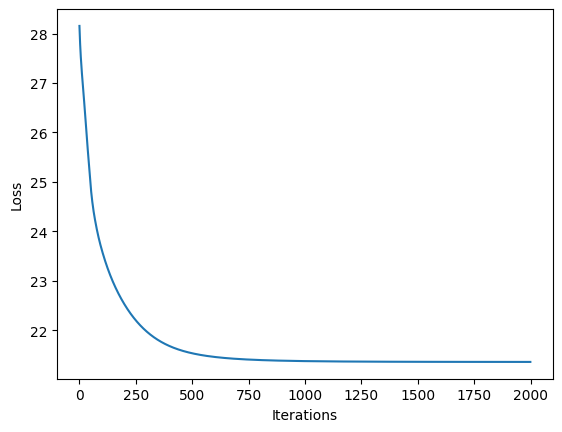

In [16]:
gpr.set_mode("model")
#Train with SVI:
adam = pyro.optim.Adam({"lr": 0.01})

svi=pyro.infer.SVI(gpr.model, gpr.guide, adam, loss=pyro.infer.Trace_ELBO())

#pyro.clear_param_store()

# Optimize the ELBO
elbo=[]
for j in range(0, 2000):
    loss=svi.step()
    elbo.append(loss)
    if j%200==0:
        print("[Iteration %04d] loss: %.4f" % (j, loss))
plot_loss(elbo)

In [18]:
#w/ prior
# param_store = pyro.get_param_store()
#param_store.keys()
#See learned values.
for i, (name, value) in enumerate(param_store.items()):
    print(f"Parameter: {name}, Value: {value}")

Parameter: kernel.kern0.variance_map, Value: 3.3626835346221924
Parameter: kernel.kern1.period_map, Value: 1.0892454385757446
Parameter: kernel.kern1.lengthscale_map, Value: 0.29857686161994934
Parameter: kernel.kern1.variance_map, Value: 0.5547628998756409
Parameter: noise, Value: 0.0016808744985610247


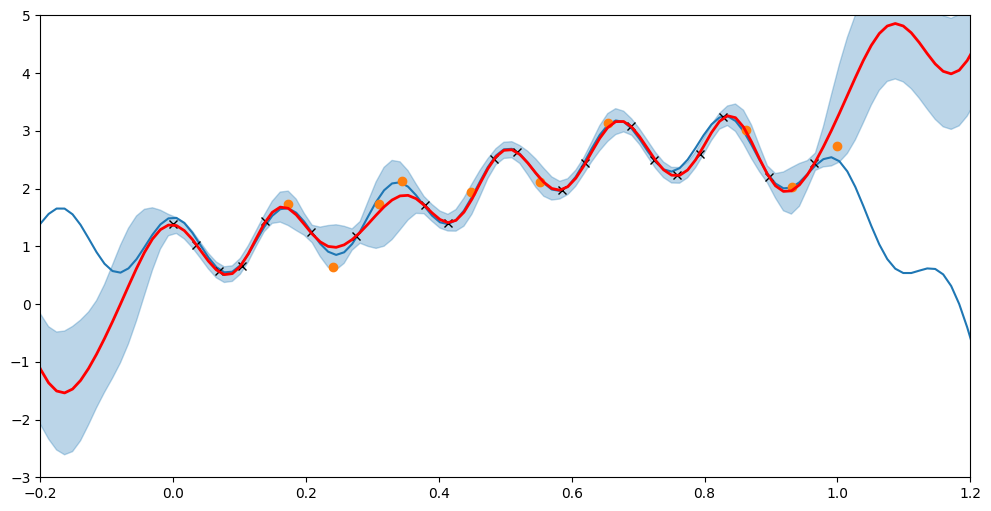

In [17]:
plot(model=gpr, plot_observed_data=True, plot_predictions=True, plot_test_data = True, plot_target_function=True, nump = False)

In [24]:
#B1.2 Compute the posterior likelihood of the test data with the MAP estimate
loc_post, cov_post = gpr(X_test.flatten(), full_cov = True)
LogLikelihood(loc_post, cov_post, y_test)

array([[1.6440353]], dtype=float32)

In [410]:
import arviz
pyro.set_rng_seed(50)
allMCest_Final = np.zeros(20)
#B1.3:
#Repeat MCMC for 20 different datasets
for k in range(20):
    n = 30
    X = torch.linspace(0, 1, 30).reshape((-1,1))
    y = g(X) + dist.Normal(0.0, np.sqrt(0.01)).sample(sample_shape=(30,)).reshape((-1,1))
    X, X_test, y, y_test = train_test_split(X, y, test_size=10)

    #Init model:
    pyro.clear_param_store()
    kernel_per = gp.kernels.Periodic(input_dim = 1)
    kernel_lin = gp.kernels.Linear(input_dim = 1)
    kernel_sum = gp.kernels.Sum(kernel_lin, kernel_per)

    gpr = gp.models.GPRegression(X = X.flatten(), y = y.flatten(), kernel = kernel_sum, noise=torch.tensor(0.1), jitter=2e-3)

    gpr.kernel.kern0.variance = pyro.nn.PyroSample(dist.LogNormal(0,5)) #I think normal not allowed 

    gpr.kernel.kern1.variance = pyro.nn.PyroSample(dist.InverseGamma(3,2)) 
    gpr.kernel.kern1.lengthscale = pyro.nn.PyroSample(dist.InverseGamma(3,1))
    gpr.kernel.kern1.period = pyro.nn.PyroSample(dist.InverseGamma(3,1))

    #NUTS part
    gpr(X.flatten())
    #Increased warmup samples to get higher ess_tail and better r_hat towards 1.
    nuts_kernel = pyro.infer.NUTS(gpr.model)
    mcmc = pyro.infer.MCMC(nuts_kernel, warmup_steps = 5000, num_samples = 100, num_chains = 5)
    mcmc.run()
    samples = mcmc.get_samples()
    
    #Now compute Loglike for the MC run:
    lin_var = samples['kernel.kern0.variance']
    per_ls = samples['kernel.kern1.lengthscale']
    per_per = samples['kernel.kern1.period']
    per_var = samples['kernel.kern1.variance']
    gpr_noise = torch.tensor(0.1).repeat(500) #Holding this fixed
    allVars = torch.dstack((torch.dstack((torch.dstack((torch.dstack((lin_var,per_ls)),per_per)),per_var)),gpr_noise))[0]
    param_store = pyro.get_param_store()
    allLikes = np.zeros(500)
    for i in range(500):
        for j, (name, value) in enumerate(param_store.items()):
            #print(f"Parameter: {name}, Value: {value}")
            param_store[name] = allVars[i,j]

        loc_post, cov_post = gpr(X_test.flatten(), full_cov = True, noiseless = False)
        m = scipy.stats.multivariate_normal(loc_post.detach().numpy(), cov_post.detach().numpy())
        allLikes[i] = m.pdf(y_test.numpy().reshape(-1))
    MCest = np.mean(allLikes)
    allMCest_Final[k] = np.log(MCest)



Warmup [1]:   0%|          | 0/5100 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/5100 [00:00, ?it/s]

Warmup [3]:   0%|          | 0/5100 [00:00, ?it/s]

Warmup [4]:   0%|          | 0/5100 [00:00, ?it/s]

Warmup [5]:   0%|          | 0/5100 [00:00, ?it/s]

/Users/Master/Documents/Kandidat/PML/Exercises/.venv/lib/python3.11/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/Master/Documents/Kandidat/PML/Exercises/.venv/lib/python3.11/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/Master/Documents/Kandidat/PML/Exercises/.venv/lib/python3.11/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 

Warmup [1]:   0%|          | 0/5100 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/5100 [00:00, ?it/s]

Warmup [3]:   0%|          | 0/5100 [00:00, ?it/s]

Warmup [4]:   0%|          | 0/5100 [00:00, ?it/s]

Warmup [5]:   0%|          | 0/5100 [00:00, ?it/s]

/Users/Master/Documents/Kandidat/PML/Exercises/.venv/lib/python3.11/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/Master/Documents/Kandidat/PML/Exercises/.venv/lib/python3.11/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/Master/Documents/Kandidat/PML/Exercises/.venv/lib/python3.11/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 

Warmup [1]:   0%|          | 0/5100 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/5100 [00:00, ?it/s]

Warmup [3]:   0%|          | 0/5100 [00:00, ?it/s]

Warmup [4]:   0%|          | 0/5100 [00:00, ?it/s]

Warmup [5]:   0%|          | 0/5100 [00:00, ?it/s]

/Users/Master/Documents/Kandidat/PML/Exercises/.venv/lib/python3.11/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/Master/Documents/Kandidat/PML/Exercises/.venv/lib/python3.11/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/Master/Documents/Kandidat/PML/Exercises/.venv/lib/python3.11/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 

Warmup [1]:   0%|          | 0/5100 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/5100 [00:00, ?it/s]

Warmup [3]:   0%|          | 0/5100 [00:00, ?it/s]

Warmup [4]:   0%|          | 0/5100 [00:00, ?it/s]

Warmup [5]:   0%|          | 0/5100 [00:00, ?it/s]

/Users/Master/Documents/Kandidat/PML/Exercises/.venv/lib/python3.11/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/Master/Documents/Kandidat/PML/Exercises/.venv/lib/python3.11/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/Master/Documents/Kandidat/PML/Exercises/.venv/lib/python3.11/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 

Warmup [1]:   0%|          | 0/5100 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/5100 [00:00, ?it/s]

Warmup [3]:   0%|          | 0/5100 [00:00, ?it/s]

Warmup [4]:   0%|          | 0/5100 [00:00, ?it/s]

Warmup [5]:   0%|          | 0/5100 [00:00, ?it/s]

/Users/Master/Documents/Kandidat/PML/Exercises/.venv/lib/python3.11/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/Master/Documents/Kandidat/PML/Exercises/.venv/lib/python3.11/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/Master/Documents/Kandidat/PML/Exercises/.venv/lib/python3.11/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 

Warmup [1]:   0%|          | 0/5100 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/5100 [00:00, ?it/s]

Warmup [3]:   0%|          | 0/5100 [00:00, ?it/s]

Warmup [4]:   0%|          | 0/5100 [00:00, ?it/s]

Warmup [5]:   0%|          | 0/5100 [00:00, ?it/s]

/Users/Master/Documents/Kandidat/PML/Exercises/.venv/lib/python3.11/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/Master/Documents/Kandidat/PML/Exercises/.venv/lib/python3.11/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/Master/Documents/Kandidat/PML/Exercises/.venv/lib/python3.11/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 

Warmup [1]:   0%|          | 0/5100 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/5100 [00:00, ?it/s]

Warmup [3]:   0%|          | 0/5100 [00:00, ?it/s]

Warmup [4]:   0%|          | 0/5100 [00:00, ?it/s]

Warmup [5]:   0%|          | 0/5100 [00:00, ?it/s]

/Users/Master/Documents/Kandidat/PML/Exercises/.venv/lib/python3.11/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/Master/Documents/Kandidat/PML/Exercises/.venv/lib/python3.11/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/Master/Documents/Kandidat/PML/Exercises/.venv/lib/python3.11/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 

Warmup [1]:   0%|          | 0/5100 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/5100 [00:00, ?it/s]

Warmup [3]:   0%|          | 0/5100 [00:00, ?it/s]

Warmup [4]:   0%|          | 0/5100 [00:00, ?it/s]

Warmup [5]:   0%|          | 0/5100 [00:00, ?it/s]

/Users/Master/Documents/Kandidat/PML/Exercises/.venv/lib/python3.11/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/Master/Documents/Kandidat/PML/Exercises/.venv/lib/python3.11/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/Master/Documents/Kandidat/PML/Exercises/.venv/lib/python3.11/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 

Warmup [1]:   0%|          | 0/5100 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/5100 [00:00, ?it/s]

Warmup [3]:   0%|          | 0/5100 [00:00, ?it/s]

Warmup [4]:   0%|          | 0/5100 [00:00, ?it/s]

Warmup [5]:   0%|          | 0/5100 [00:00, ?it/s]

/Users/Master/Documents/Kandidat/PML/Exercises/.venv/lib/python3.11/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/Master/Documents/Kandidat/PML/Exercises/.venv/lib/python3.11/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/Master/Documents/Kandidat/PML/Exercises/.venv/lib/python3.11/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 

Warmup [1]:   0%|          | 0/5100 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/5100 [00:00, ?it/s]

Warmup [3]:   0%|          | 0/5100 [00:00, ?it/s]

Warmup [4]:   0%|          | 0/5100 [00:00, ?it/s]

Warmup [5]:   0%|          | 0/5100 [00:00, ?it/s]

/Users/Master/Documents/Kandidat/PML/Exercises/.venv/lib/python3.11/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/Master/Documents/Kandidat/PML/Exercises/.venv/lib/python3.11/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/Master/Documents/Kandidat/PML/Exercises/.venv/lib/python3.11/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 

Warmup [1]:   0%|          | 0/5100 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/5100 [00:00, ?it/s]

Warmup [3]:   0%|          | 0/5100 [00:00, ?it/s]

Warmup [4]:   0%|          | 0/5100 [00:00, ?it/s]

Warmup [5]:   0%|          | 0/5100 [00:00, ?it/s]

/Users/Master/Documents/Kandidat/PML/Exercises/.venv/lib/python3.11/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/Master/Documents/Kandidat/PML/Exercises/.venv/lib/python3.11/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/Master/Documents/Kandidat/PML/Exercises/.venv/lib/python3.11/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 

Warmup [1]:   0%|          | 0/5100 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/5100 [00:00, ?it/s]

Warmup [3]:   0%|          | 0/5100 [00:00, ?it/s]

Warmup [4]:   0%|          | 0/5100 [00:00, ?it/s]

Warmup [5]:   0%|          | 0/5100 [00:00, ?it/s]

/Users/Master/Documents/Kandidat/PML/Exercises/.venv/lib/python3.11/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/Master/Documents/Kandidat/PML/Exercises/.venv/lib/python3.11/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/Master/Documents/Kandidat/PML/Exercises/.venv/lib/python3.11/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 

Warmup [1]:   0%|          | 0/5100 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/5100 [00:00, ?it/s]

Warmup [3]:   0%|          | 0/5100 [00:00, ?it/s]

Warmup [4]:   0%|          | 0/5100 [00:00, ?it/s]

Warmup [5]:   0%|          | 0/5100 [00:00, ?it/s]

/Users/Master/Documents/Kandidat/PML/Exercises/.venv/lib/python3.11/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/Master/Documents/Kandidat/PML/Exercises/.venv/lib/python3.11/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/Master/Documents/Kandidat/PML/Exercises/.venv/lib/python3.11/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 

Warmup [1]:   0%|          | 0/5100 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/5100 [00:00, ?it/s]

Warmup [3]:   0%|          | 0/5100 [00:00, ?it/s]

Warmup [4]:   0%|          | 0/5100 [00:00, ?it/s]

Warmup [5]:   0%|          | 0/5100 [00:00, ?it/s]

/Users/Master/Documents/Kandidat/PML/Exercises/.venv/lib/python3.11/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/Master/Documents/Kandidat/PML/Exercises/.venv/lib/python3.11/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/Master/Documents/Kandidat/PML/Exercises/.venv/lib/python3.11/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 

Warmup [1]:   0%|          | 0/5100 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/5100 [00:00, ?it/s]

Warmup [3]:   0%|          | 0/5100 [00:00, ?it/s]

Warmup [4]:   0%|          | 0/5100 [00:00, ?it/s]

Warmup [5]:   0%|          | 0/5100 [00:00, ?it/s]

/Users/Master/Documents/Kandidat/PML/Exercises/.venv/lib/python3.11/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/Master/Documents/Kandidat/PML/Exercises/.venv/lib/python3.11/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/Master/Documents/Kandidat/PML/Exercises/.venv/lib/python3.11/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 

Warmup [1]:   0%|          | 0/5100 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/5100 [00:00, ?it/s]

Warmup [3]:   0%|          | 0/5100 [00:00, ?it/s]

Warmup [4]:   0%|          | 0/5100 [00:00, ?it/s]

Warmup [5]:   0%|          | 0/5100 [00:00, ?it/s]

/Users/Master/Documents/Kandidat/PML/Exercises/.venv/lib/python3.11/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/Master/Documents/Kandidat/PML/Exercises/.venv/lib/python3.11/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/Master/Documents/Kandidat/PML/Exercises/.venv/lib/python3.11/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 

Warmup [1]:   0%|          | 0/5100 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/5100 [00:00, ?it/s]

Warmup [3]:   0%|          | 0/5100 [00:00, ?it/s]

Warmup [4]:   0%|          | 0/5100 [00:00, ?it/s]

Warmup [5]:   0%|          | 0/5100 [00:00, ?it/s]

/Users/Master/Documents/Kandidat/PML/Exercises/.venv/lib/python3.11/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/Master/Documents/Kandidat/PML/Exercises/.venv/lib/python3.11/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/Master/Documents/Kandidat/PML/Exercises/.venv/lib/python3.11/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 

Warmup [1]:   0%|          | 0/5100 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/5100 [00:00, ?it/s]

Warmup [3]:   0%|          | 0/5100 [00:00, ?it/s]

Warmup [4]:   0%|          | 0/5100 [00:00, ?it/s]

Warmup [5]:   0%|          | 0/5100 [00:00, ?it/s]

/Users/Master/Documents/Kandidat/PML/Exercises/.venv/lib/python3.11/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/Master/Documents/Kandidat/PML/Exercises/.venv/lib/python3.11/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/Master/Documents/Kandidat/PML/Exercises/.venv/lib/python3.11/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 

Warmup [1]:   0%|          | 0/5100 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/5100 [00:00, ?it/s]

Warmup [3]:   0%|          | 0/5100 [00:00, ?it/s]

Warmup [4]:   0%|          | 0/5100 [00:00, ?it/s]

Warmup [5]:   0%|          | 0/5100 [00:00, ?it/s]

/Users/Master/Documents/Kandidat/PML/Exercises/.venv/lib/python3.11/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/Master/Documents/Kandidat/PML/Exercises/.venv/lib/python3.11/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/Master/Documents/Kandidat/PML/Exercises/.venv/lib/python3.11/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 

Warmup [1]:   0%|          | 0/5100 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/5100 [00:00, ?it/s]

Warmup [3]:   0%|          | 0/5100 [00:00, ?it/s]

Warmup [4]:   0%|          | 0/5100 [00:00, ?it/s]

Warmup [5]:   0%|          | 0/5100 [00:00, ?it/s]

/Users/Master/Documents/Kandidat/PML/Exercises/.venv/lib/python3.11/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/Master/Documents/Kandidat/PML/Exercises/.venv/lib/python3.11/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/Master/Documents/Kandidat/PML/Exercises/.venv/lib/python3.11/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 

In [411]:
allMCest_Final

array([-5.29007489, -4.46042183, -5.07452168, -5.38706506, -6.09132614,
       -4.92042614, -5.79366594, -5.10454924, -4.85947535, -5.63332944,
       -4.53626069, -4.67539009, -4.18592182, -6.61098929, -4.77351209,
       -5.63235058, -4.60162261, -3.98202312, -6.71179716, -6.28558316])

In [412]:
np.mean(allMCest_Final)

-5.230515316101353

In [413]:
np.std(allMCest_Final)

0.7594235822872258

In [429]:
#This is just to run single MCMC to see diagnostics
X = torch.linspace(0, 1, 30).reshape((-1,1))
y = g(X) + dist.Normal(0.0, np.sqrt(0.01)).sample(sample_shape=(30,)).reshape((-1,1))
X, X_test, y, y_test = train_test_split(X, y, test_size=10)

kernel_per = gp.kernels.Periodic(input_dim = 1)
kernel_lin = gp.kernels.Linear(input_dim = 1)
kernel_sum = gp.kernels.Sum(kernel_lin, kernel_per)

gpr = gp.models.GPRegression(X = X.flatten(), y = y.flatten(), kernel = kernel_sum, noise=torch.tensor(0.1), jitter=2e-3)

gpr.kernel.kern0.variance = pyro.nn.PyroSample(dist.LogNormal(0,5)) #I think normal not allowed 

gpr.kernel.kern1.variance = pyro.nn.PyroSample(dist.InverseGamma(3,2)) 
gpr.kernel.kern1.lengthscale = pyro.nn.PyroSample(dist.InverseGamma(3,1))
gpr.kernel.kern1.period = pyro.nn.PyroSample(dist.InverseGamma(3,1))

#NUTS part
gpr(X.flatten())
#Increased warmup samples to get higher ess_tail and better r_hat towards 1.
nuts_kernel = pyro.infer.NUTS(gpr.model)
mcmc_test = pyro.infer.MCMC(nuts_kernel, warmup_steps = 5000, num_samples = 100, num_chains = 5)
mcmc_test.run()
samples_test = mcmc_test.get_samples()

Warmup [1]:   0%|          | 0/5100 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/5100 [00:00, ?it/s]

Warmup [3]:   0%|          | 0/5100 [00:00, ?it/s]

Warmup [4]:   0%|          | 0/5100 [00:00, ?it/s]

Warmup [5]:   0%|          | 0/5100 [00:00, ?it/s]

/Users/Master/Documents/Kandidat/PML/Exercises/.venv/lib/python3.11/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/Master/Documents/Kandidat/PML/Exercises/.venv/lib/python3.11/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/Master/Documents/Kandidat/PML/Exercises/.venv/lib/python3.11/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 

In [431]:
data_test = arviz.from_pyro(mcmc_test)
summary = arviz.summary(data_test)
print(summary)

                            mean       sd  hdi_3%  hdi_97%  mcse_mean  \
kernel.kern0.variance     88.442  602.310   0.000  167.398     35.759   
kernel.kern1.lengthscale   1.348    0.881   0.195    2.941      0.187   
kernel.kern1.period        0.859    0.803   0.161    2.392      0.257   
kernel.kern1.variance      1.051    0.654   0.282    2.390      0.058   

                          mcse_sd  ess_bulk  ess_tail  r_hat  
kernel.kern0.variance      25.312      52.0      71.0   1.09  
kernel.kern1.lengthscale    0.134      17.0      55.0   1.23  
kernel.kern1.period         0.187       8.0     170.0   1.77  
kernel.kern1.variance       0.041      89.0     137.0   1.06  


/Users/Master/Documents/Kandidat/PML/Exercises/.venv/lib/python3.11/site-packages/arviz/data/io_pyro.py:157: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


array([<Axes: title={'center': 'kernel.kern0.variance'}>,
       <Axes: title={'center': 'kernel.kern1.lengthscale'}>,
       <Axes: title={'center': 'kernel.kern1.period'}>,
       <Axes: title={'center': 'kernel.kern1.variance'}>], dtype=object)

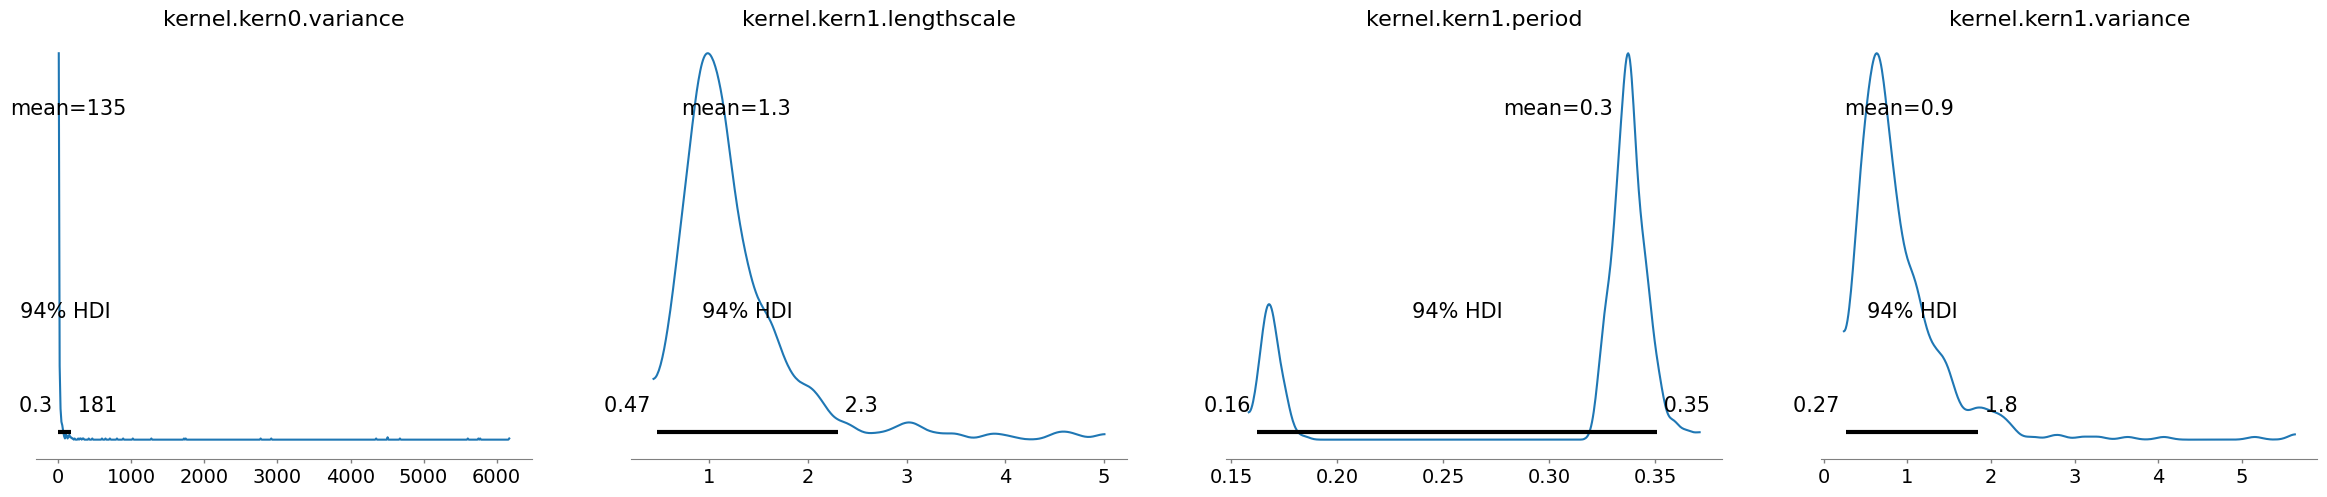

In [37]:
arviz.plot_posterior(data_test)

/Users/Master/Documents/Kandidat/PML/Exercises/.venv/lib/python3.11/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


array([[<Axes: title={'center': 'kernel.kern0.variance'}>,
        <Axes: title={'center': 'kernel.kern0.variance'}>],
       [<Axes: title={'center': 'kernel.kern1.lengthscale'}>,
        <Axes: title={'center': 'kernel.kern1.lengthscale'}>],
       [<Axes: title={'center': 'kernel.kern1.period'}>,
        <Axes: title={'center': 'kernel.kern1.period'}>],
       [<Axes: title={'center': 'kernel.kern1.variance'}>,
        <Axes: title={'center': 'kernel.kern1.variance'}>]], dtype=object)

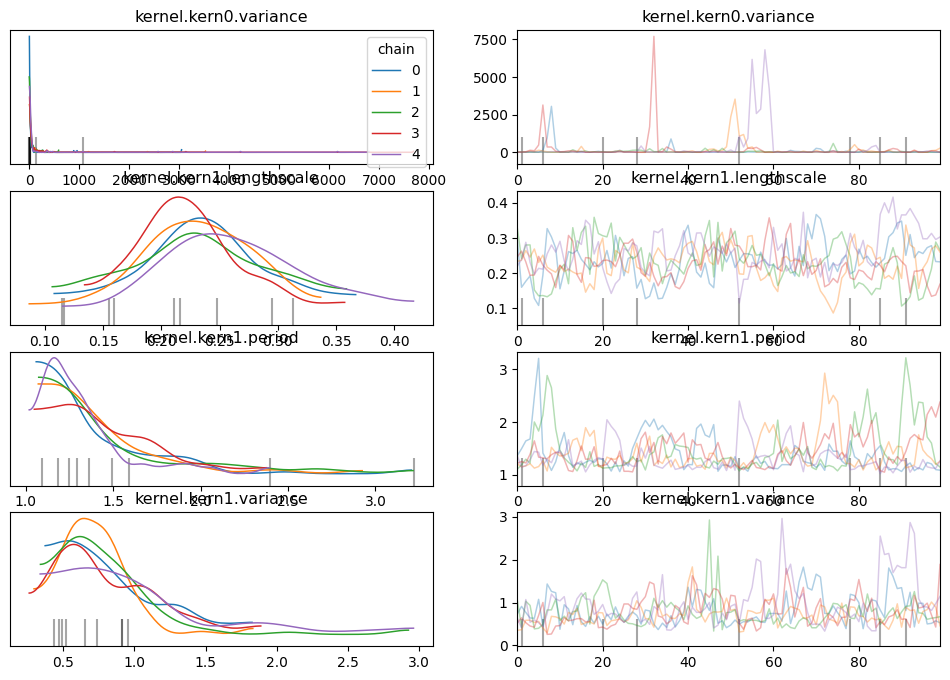

In [430]:
arviz.plot_trace(data_test, compact = False, legend=True)

In [401]:
#Repeat procedure 20 for for SVI optim:
pyro.set_rng_seed(50)
allSviLogLike = np.zeros(20)
for k in range(20):
    pyro.clear_param_store()
    n = 30
    X = torch.linspace(0, 1, 30).reshape((-1,1))
    y = g(X) + dist.Normal(0.0, np.sqrt(0.01)).sample(sample_shape=(30,)).reshape((-1,1))
    X, X_test, y, y_test = train_test_split(X, y, test_size=10)

    kernel_per = gp.kernels.Periodic(input_dim = 1)
    kernel_lin = gp.kernels.Linear(input_dim = 1)
    kernel_sum = gp.kernels.Sum(kernel_lin, kernel_per)

    gpr = gp.models.GPRegression(X = X.flatten(), y = y.flatten(), kernel = kernel_sum, noise=torch.tensor(0.1), jitter=2e-3)

    gpr.kernel.kern0.variance = pyro.nn.PyroSample(dist.LogNormal(0,5)) #I think normal not allowed 

    gpr.kernel.kern1.variance = pyro.nn.PyroSample(dist.InverseGamma(3,2)) 
    gpr.kernel.kern1.lengthscale = pyro.nn.PyroSample(dist.InverseGamma(3,1))
    gpr.kernel.kern1.period = pyro.nn.PyroSample(dist.InverseGamma(3,1))
    
    #Train with SVI:
    gpr.set_mode("model")
    adam = pyro.optim.Adam({"lr": 0.01})
    svi=pyro.infer.SVI(gpr.model, gpr.guide, adam, loss=pyro.infer.Trace_ELBO())
    #pyro.clear_param_store()

    # Optimize the ELBO
    #elbo=[]
    for j in range(0, 2000):
        loss=svi.step()
        #elbo.append(loss)
        #if j%200==0:
        #    print("[Iteration %04d] loss: %.4f" % (j, loss))
    #plot_loss(elbo)
    loc_post, cov_post = gpr(X_test.flatten(), full_cov = True, noiseless = False)
    #logLikeSample = LogLikelihood(loc_post, cov_post, y_test)
    m = scipy.stats.multivariate_normal(loc_post.detach().numpy(), cov_post.detach().numpy())
    likeSample = m.logpdf(y_test.numpy().reshape(-1))
    allSviLogLike[k] =likeSample
    #allSviLogLike[k] = logLikeSample.item()

In [402]:
np.mean(allSviLogLike)

-24.23658744412465

In [403]:
np.std(allSviLogLike)

46.13042825079498

In [24]:
#B2.3
l = 101
X_2 = torch.linspace(0,1, l).reshape(-1,1)
w = torch.tensor(1/(l-1)).repeat((l,1))   
#change first and last element
w[0] = 1/(2*l-1)
w[-1] = 1/(2*l-1)

#For now use some random parameters for the kernel
eta = [1,2,3,4]
#need to test for q_hat = {0, 5, 10}, start with 5
q_hat = 5
K = gpr.kernel.forward(X_2,X_2)

In [25]:
#Defining parameters of the Gaussian process
#f_mu = w.T@K*(w.T@K@w)**-1*q_hat
#f_Sigma = K - w.T@K*(w.T@K@w)**-1*K@w
f_mu = K@w*(w.T@K@w)**-1*q_hat
f_Sigma = K - K@w*(w.T@K@w)**-1*w.T@K

In [26]:
#Check if for positive definiteness if all eigenvalues are positive
torch.any(torch.linalg.eigh(f_Sigma + 1e-4*torch.eye(l))[0] <= 0.0)
#torch.min(torch.linalg.eigh(f_Sigma)[0])

tensor(False)

In [28]:
f_dist = torch.distributions.MultivariateNormal(f_mu.view(-1), f_Sigma + 1e-3 * torch.eye(101))
sample = f_dist.sample((5,))

In [29]:
w.T @ sample[0]

tensor([4.9951])

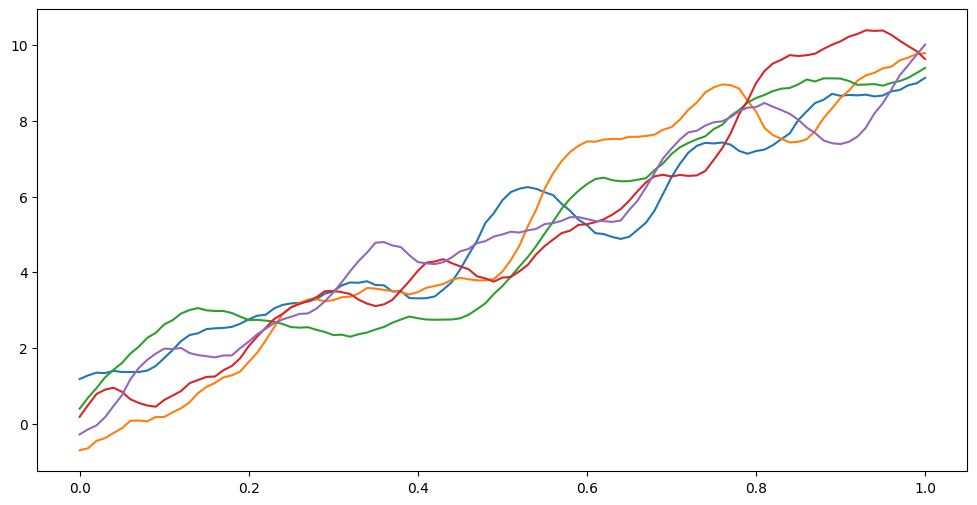

In [31]:
fig, ax = plt.subplots(figsize=(12, 6))
for i in range(5):
    ax.plot(X_2.flatten(), sample[i])

In [32]:
def conditional(X, y, X_predict, noise_var, kernel):
  #kernel_matrix = np.array([[kernel(X[row].reshape(-1,1), X[col].reshape(-1,1), eta) for col in range(len(y))] for row in range(len(y))]).reshape((len(X), len(X)))
  kernel_matrix = kernel(X)
  G = torch.linalg.inv(kernel_matrix + noise_var * torch.eye(len(y)))
  k1 = kernel(X, X_predict)
  
  mustar = k1.T @ G @ y
  Sigmastar = kernel(X_predict) - k1.T @ G @ k1
  # See eq. 66 in the lecture notes. Note that there is a small error: Instead of (S) it should be K(S)

  return mustar, Sigmastar # return mean and covariance matrix

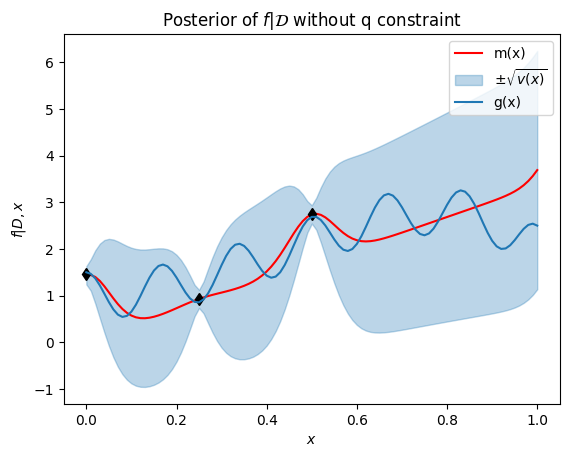

In [35]:
l = 101
D_x = torch.tensor([0, 0.25, 0.5])
D_y = torch.tensor([1.46, 0.93, 2.76])
X_predict = torch.linspace(0,1,l)
y_pred_mu, y_pred_Sigma = conditional(D_x, D_y, X_predict, 0.01, gpr.kernel.forward)
#y_pred_mu = y_pred_mu_ * D_y_std + D_y_mean
plt.plot(X_predict, y_pred_mu.detach().numpy(), "red", label="m(x)")
plt.fill_between(
            X_predict,  # plot the two-sigma uncertainty about the mean
            (y_pred_mu - torch.tensor(1.96) * y_pred_Sigma.diag().sqrt()).detach().numpy(),
            (y_pred_mu + torch.tensor(1.96) * y_pred_Sigma.diag().sqrt()).detach().numpy(),
            color="C0",
            alpha=0.3,
            label="$\pm \sqrt{v(x)}$"
        )
plt.plot(D_x, D_y, "kd")
plt.plot(X_predict, g(X_predict), label="g(x)")
plt.title("Posterior of $f|\mathcal{D}$ without q constraint")
plt.xlabel("$x$")
plt.ylabel("$f|D,x$")
plt.legend()
plt.savefig("posterior-no-q")

plt.show()

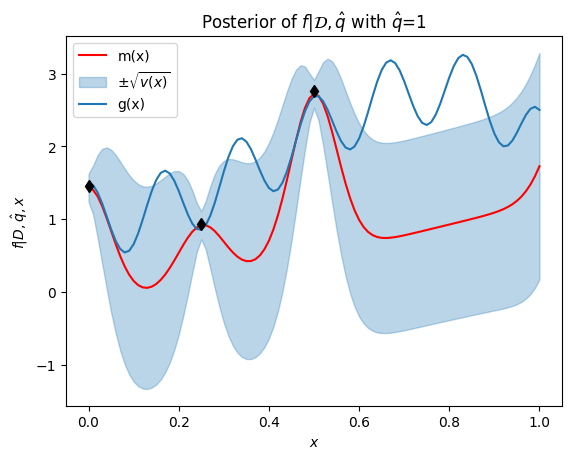

In [42]:
y_pred_mu, y_pred_Sigma = conditional(D_x, D_y, X_predict, 0.01, gpr.kernel.forward)
#y_pred_mu = y_pred_mu_ * D_y_std + D_y_mean
l = 101
w = torch.tensor(1/(l-1)).repeat((l,1))   
#change first and last element
w[0] = 1/(2*l-2)
w[-1] = 1/(2*l-2)

q_hat = torch.tensor(1)
K = y_pred_Sigma
f_mu = y_pred_mu + (K@w*(w.T@K@w)**-1*(q_hat - w.T @ y_pred_mu)).view(-1)
f_Sigma = K - K@w*(w.T@K@w)**-1*w.T@K
#f_mu = f_mu_ * D_y_std + D_y_mean

plt.plot(X_predict, (f_mu).detach().numpy(), "red", label="m(x)")
plt.fill_between(
            X_predict,  # plot the two-sigma uncertainty about the mean
            (f_mu - torch.tensor(1.95) * f_Sigma.diag().sqrt()).detach().numpy(),
            (f_mu + torch.tensor(1.95) * f_Sigma.diag().sqrt()).detach().numpy(),
            color="C0",
            alpha=0.3,
            label="$\pm \sqrt{v(x)}$"
        )
plt.plot(X_predict, g(X_predict), label="g(x)")
plt.plot(D_x, D_y, "kd")
#plt.plot(X[:5], y.view(-1)[:5], "kx")
#plt.plot(X.view(-1), y.view(-1), "kx")
plt.title("Posterior of $f|\mathcal{D},\hat{q}$ with $\hat{q}$"+f"={q_hat}")
plt.xlabel("$x$")
plt.ylabel("$f|D,\hat{q},x$")
plt.legend()
plt.savefig("posterior-w-q")

plt.show()

In [ ]:
samples = torch.distributions.MultivariateNormal(f_mu.view(-1), f_Sigma + 1e-4 * torch.eye(X_predict.size(0))).sample((100,))
np.mean([w.T @ samples[i] for i in range(100)])

In [ ]:
w.T @ f_mu_.view(-1)